<a href="https://colab.research.google.com/github/ilinashah177/Coursework-Website/blob/main/nitrousoxidepercapitastepwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install statsmodels pandas numpy

import pandas as pd
import numpy as np
import statsmodels.api as sm

In [14]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving NitrousOxideStepwise.xlsx to NitrousOxideStepwise.xlsx


In [15]:
import pandas as pd

# Name of uploaded file
file_name = 'NitrousOxideStepwise.xlsx'

# Read data from the required sheet
df = pd.read_excel(file_name, sheet_name='Sheet1', engine='openpyxl') # Pass file_name and specify sheet_name

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df

,Year,BRI Investments (USD millions),Urbanization (% of urban population),GDP (USD Billion),Per capita nitrous oxide emissions (tonnes of CO2 equivalents per person)
0,2015,520.40,36.03,299.96,0.25
1,2016,893.25,36.23,313.63,0.26
2,2017,2296.00,36.44,339.21,0.28
3,2018,2062.00,36.67,356.13,0.28
4,2019,2907.00,36.91,320.91,0.29
5,2020,1600.00,37.16,300.43,0.29
6,2021,2400.00,37.44,348.52,0.29
7,2022,2716.00,37.73,374.79,0.30
8,2023,1440.00,38.04,338.37,0.30


In [16]:
#Generate summary statistics, and round everything to 2 decimal places
summary=df.describe().round(2)
summary

,Year,BRI Investments (USD millions),Urbanization (% of urban population),GDP (USD Billion),Per capita nitrous oxide emissions (tonnes of CO2 equivalents per person)
count,9.00,9.00,9.00,9.00,9.00
mean,2019.00,1870.52,36.96,332.44,0.28
std,2.74,815.75,0.69,25.64,0.02
min,2015.00,520.40,36.03,299.96,0.25
25%,2017.00,1440.00,36.44,313.63,0.28
50%,2019.00,2062.00,36.91,338.37,0.29
75%,2021.00,2400.00,37.44,348.52,0.29
max,2023.00,2907.00,38.04,374.79,0.30


In [17]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    # Initialize df with data_cleaned to ensure it's defined
    df = df.copy()

    # Drop rows with any missing values
    df = df.dropna()

    while True:
        #Adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        #Drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        #Drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        #If the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            #If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            #No VIF is above threshold, exit the loop
            break

    return df

In [19]:
predictor_vars=['BRI Investments (USD millions)', 'Urbanization (% of urban population)', 'GDP (USD Billion)']

vif = drop_column_using_vif_(df[predictor_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 1.9508390437691314
The columns remaining after VIF selection are:
Index(['BRI Investments (USD millions)',
       'Urbanization (% of urban population)', 'GDP (USD Billion)'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Matrix')

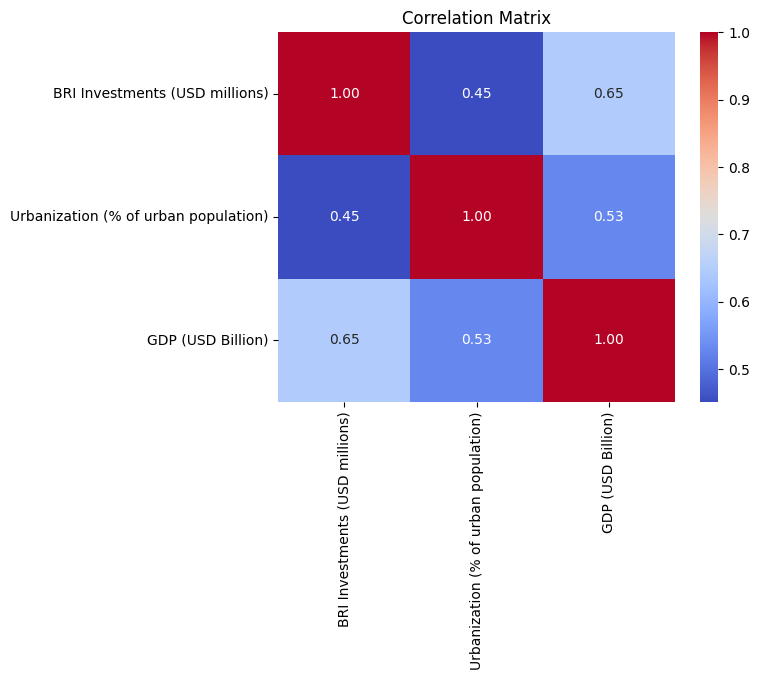

In [20]:
!pip install seaborn # install seaborn
import seaborn as sns # import seaborn
import matplotlib.pyplot as plt # import pyplot for using title

sns.heatmap(df[['BRI Investments (USD millions)', 'Urbanization (% of urban population)', 'GDP (USD Billion)']].corr(), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [21]:
#Define dependent variable (environmental indicator, e.g., CO2 emissions)
y = df['Per capita nitrous oxide emissions (tonnes of CO2 equivalents per person)']  # This is your dependent variable

#Define the independent variables (explanatory variables)
X = df[['BRI Investments (USD millions)', 'Urbanization (% of urban population)', 'GDP (USD Billion)']]

#Add a constant term (intercept) to the model
X = sm.add_constant(X)

In [24]:
#Function to perform Stepwise Regression
def stepwise_regression(X, y, direction="both", threshold_in=0.05, threshold_out=0.10):
    """
    Performs stepwise regression using both forward and backward elimination.
    """
    initial_list = X.columns.tolist()
    while True:
        changed = False
        #Forward Step: Adding variables to the model
        if direction in ["both", "forward"]:
            model = sm.OLS(y, X[initial_list]).fit()
            p_values = model.pvalues[1:]  # Exclude intercept
            max_p_value = p_values.max()
            if max_p_value > threshold_in:
                excluded_var = p_values.idxmax()
                initial_list.remove(excluded_var)
                changed = True

        #Backward Step: Removing variables from the model
        if direction in ["both", "backward"]:
            model = sm.OLS(y, X[initial_list]).fit()
            p_values = model.pvalues[1:]  # Exclude intercept
            max_p_value = p_values.max()
            if max_p_value > threshold_out:
                excluded_var = p_values.idxmax()
                initial_list.remove(excluded_var)
                changed = True

        # If no change, break the loop
        if not changed:
            break

    # Final model with selected variables
    final_model = sm.OLS(y, X[initial_list]).fit()
    return final_model

# Perform stepwise regression
stepwise_model = stepwise_regression(X, y)

# Print the summary of the final model
print(stepwise_model.summary())

                                                        OLS Regression Results                                                       
Dep. Variable:     Per capita nitrous oxide emissions (tonnes of CO2 equivalents per person)   R-squared:                       0.951
Model:                                                                                   OLS   Adj. R-squared:                  0.934
Method:                                                                        Least Squares   F-statistic:                     57.83
Date:                                                                       Sun, 26 Jan 2025   Prob (F-statistic):           0.000120
Time:                                                                               22:09:50   Log-Likelihood:                 37.889
No. Observations:                                                                          9   AIC:                            -69.78
Df Residuals:                                                 

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


In [25]:
import statsmodels.stats.api as sms

# Perform Breusch-Pagan test
bp_test = sms.het_breuschpagan(stepwise_model.resid, stepwise_model.model.exog)

# Print the results
print("Breusch-Pagan test results:")
print(f"Lagrange multiplier statistic: {bp_test[0]:.4f}")
print(f"p-value: {bp_test[1]:.4f}")
print(f"f-value: {bp_test[2]:.4f}")
print(f"f p-value: {bp_test[3]:.4f}")

# Interpret the results
# If p-value is less than significance level of 0.05,
# reject the null hypothesis of homoskedasticity,
# indicating the presence of heteroskedasticity

Breusch-Pagan test results:
Lagrange multiplier statistic: 0.2796
p-value: 0.8695
f-value: 0.0962
f p-value: 0.9097
